In [1]:
import matplotlib.pyplot as plt
import numpy as np

#import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config
#import primary model choices
import crflux.models as pm

In [26]:
def rejection_sampler(p,xbounds,pmax):
    while True:
        x = np.random.rand(1)*(xbounds[1]-xbounds[0])+xbounds[0]
        y = np.random.rand(1)*pmax
        if y<=p(x):
            return x

In [25]:
def restricted_rej_sampler(p, xbounds, pmax, xlimits):
    while True:
        x = np.random.rand(1)*(xbounds[1]-xbounds[0])+xbounds[0]
        if not (xlimits[0] <= x <= xlimits[1]):
            continue
        y = np.random.rand(1)*pmax
        if y<=p(x):
            return x

In [31]:
def plim(x):
    return np.sin(x)

nevents = 100000
dist1 = [restricted_rej_sampler(plim,(0, 3.14),1.1, (0.5, 2.5)) for _ in range(nevents)]


Text(0.5, 0, 'Energy, eV')

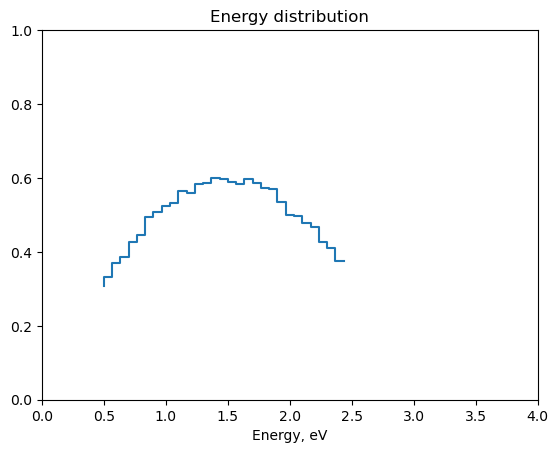

In [32]:
gr, cnt = np.histogram(dist1, 30)
# plt.semilogx()
plt.step(cnt[:-1], gr/((cnt[1]-cnt[0])*nevents))
# plt.step(10**cnt[:-1]*1e9, gr)
plt.title("Energy distribution")
plt.ylim(0,1)
plt.xlim(0,4)
plt.xlabel("Energy, eV")


In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
primary_model = (pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [170]:
mceq_run.pman.pdg2mceqidx

{(-11, 0): 0,
 (11, 0): 1,
 (-12, 0): 2,
 (12, 0): 3,
 (-13, -1): 4,
 (-13, 0): 5,
 (-13, 1): 6,
 (13, -1): 7,
 (13, 0): 8,
 (13, 1): 9,
 (-14, 0): 10,
 (14, 0): 11,
 (-16, 0): 12,
 (16, 0): 13,
 (22, 0): 14,
 (111, 0): 15,
 (130, 0): 16,
 (-211, 0): 17,
 (211, 0): 18,
 (310, 0): 19,
 (-321, 0): 20,
 (321, 0): 21,
 (-411, 0): 22,
 (411, 0): 23,
 (-421, 0): 24,
 (421, 0): 25,
 (-431, 0): 26,
 (431, 0): 27,
 (-2112, 0): 28,
 (2112, 0): 29,
 (-2212, 0): 30,
 (2212, 0): 31,
 (-3122, 0): 32,
 (3122, 0): 33,
 (-1000012, 0): 34,
 (1000012, 0): 35,
 (-1000013, -1): 36,
 (-1000013, 1): 37,
 (1000013, -1): 38,
 (1000013, 1): 39,
 (-1000014, 0): 40,
 (1000014, 0): 41,
 (-1010012, 0): 42,
 (1010012, 0): 43,
 (-1010013, -1): 44,
 (-1010013, 1): 45,
 (1010013, -1): 46,
 (1010013, 1): 47,
 (-1010014, 0): 48,
 (1010014, 0): 49,
 (-1020012, 0): 50,
 (1020012, 0): 51,
 (-1020014, 0): 52,
 (1020014, 0): 53,
 (-1030012, 0): 54,
 (1030012, 0): 55,
 (-1030014, 0): 56,
 (1030014, 0): 57,
 (-1040012, 0): 58,


In [3]:
e_grid = mceq_run._energy_grid
# print(e_grid)

In [4]:
from MCEq import particlemanager
from particletools.tables import PYTHIAParticleData

pythia_pdata = PYTHIAParticleData()
print(pythia_pdata.decay_channels(13))

[(1.0, [-12, 11, 14])]


In [27]:

class ParticleDecay:
    from MCEq.core import MCEqRun
    import crflux.models as pm
    from particletools.tables import PYTHIAParticleData
    from scipy.interpolate import interp1d
    
    def __init__(self):
        self.pythia_pdata = self.PYTHIAParticleData()
        self.mceq_run = self.MCEqRun(
            interaction_model='SIBYLL2.3c',
            primary_model = (self.pm.HillasGaisser2012, "H3a"),
            theta_deg=0.0)
        
    def set_decayed_particle(self, pid, etot):
        
        mcr = self.mceq_run    
        self.particle = particlemanager.MCEqParticle(pid, 0, mcr._energy_grid)
        self.particle.set_decay_channels(mcr._decays, mcr.pman)
        self.particle_mass = pythia_pdata.mass(pid)
        
        
        self.etot = etot
        self.ekin = self.etot - self.particle_mass
        
        # Set decay channels
        self.decay_channels = self.pythia_pdata.decay_channels(pid)
        self.decay_probabilities = [channel[0] for channel in self.decay_channels]  
    
    
    def _child_particle_pdf(self, pid):
        self.child = self.get_mceq_particle(pid)
        data = self.particle.dNdec_dxlab(self.ekin, self.child)
        self.xgrid = data[0]
        self.pdf_max = np.max(data[1])
        self.pdf = self.interp1d(*data)
        
    def decay_products(self):
        ind = np.argmax(np.random.multinomial(1, self.decay_probabilities, size=1))
        decay_pids = self.decay_channels[ind][1]
        return self.decay_channels[ind][1]
    
    
    def get_child_particle(self, pid):
        child = self.get_mceq_particle(pid)
        data = self.particle.dNdec_dxlab(self.ekin, child)
        self.xgrid = data[0]
        self.pdf_max = np.max(data[1])
        self.pdf = self.interp1d(*data)
        
        xpart = restricted_rej_sampler(self.pdf,
                                  (self.xgrid[0], self.xgrid[-1]),
                                  self.pdf_max,
                                  (self.xgrid[0], self.xleft))
        
        self.xleft -= (xpart + pythia_pdata.mass(pid)/self.ekin)
        return (pid, xpart*self.ekin + pythia_pdata.mass(pid))
    
    def get_last_child_particle(self, pid):
        return (pid, self.xleft*self.ekin + self.particle_mass)   
    
    
    def get_mceq_particle(self, pid):
        for child in self.particle.decay_dists:
            if child.pdg_id[0] == pid:
                return mceq_run.pman[child.pdg_id]
    
    
    
    def get_products(self):
        
        self.xleft = 1.0 # part of kinetic energy left for child particle
        self.xarray = []
        
        
        decay_products = self.decay_products()
        decay_size = len(decay_products)
        
        result = []
        
        for pid in decay_products:
            if decay_size > 1:
                result.append(self.get_child_particle(pid))
                decay_size -= 1
            else:   
                result.append(self.get_last_child_particle(pid))
            
        return result    
                

In [28]:
pdec = ParticleDecay()


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [45]:
pdec.set_decayed_particle(321, 100)

pdec.get_products()

[(211, array([51.52223474])), (111, array([48.47776526]))]

In [165]:
tot = 0
for ipr in pdec.get_products():
    tot += ipr[1]

print(tot)    

[100.]


In [ ]:

# tot = 0
# br_ratio = []
# for i, val in  enumerate(pythia_pdata.decay_channels(321)):
#     br_ratio.append(val[0])
# print(br_ratio) 
# ind = np.argmax(np.random.multinomial(1, br_ratio, size=1)) 
# part = pythia_pdata.decay_channels(321)[ind]
# part[1] 

ch = pythia_pdata.decay_channels(321)
ind = np.argmax(np.random.multinomial(1, [x[0] for x in ch], size=1))
part = ch[ind]
part

In [18]:
pp = particlemanager.MCEqParticle(321, 0, mceq_run._energy_grid)
pp.set_decay_channels(mceq_run._decays, mceq_run.pman)

res = None
for pps in pp.decay_dists:
    # print(pps.pdg_id)
    if pps.pdg_id[0] == -13:
        res = mceq_run.pman[pps.pdg_id]
        break
        
res

def find_particle(pid):
    for pps in pp.decay_dists:
        if pps.pdg_id[0] == pid:
            return mceq_run.pman[pps.pdg_id]
    
# pp.decay_dists[(-13, -1)]
# pp.pdg2mceqidx

# mceq_run.pman[(-13, -1)]

# def get


        mu+_l:
        is_hadron     : False
        is_lepton     : True
        is_nucleus    : False
        is_stable     : False
        is_mixed      : False
        is_resonance  : False
        is_tracking   : False
        is_projectile : False
        mceqidx       : 4
        E_mix         : 0.0e+00 GeV

In [ ]:


data = pp.dNdec_dxlab(1e3, mceq_run.pman[11])
from scipy.interpolate import interp1d
f = interp1d(*data)
pmax1 = np.max(data[1])
xgrid = data[0]
# pp.decay_dists
# # pp.
plt.plot(xgrid, f(xgrid))

Text(0.5, 0, 'Energy, eV')

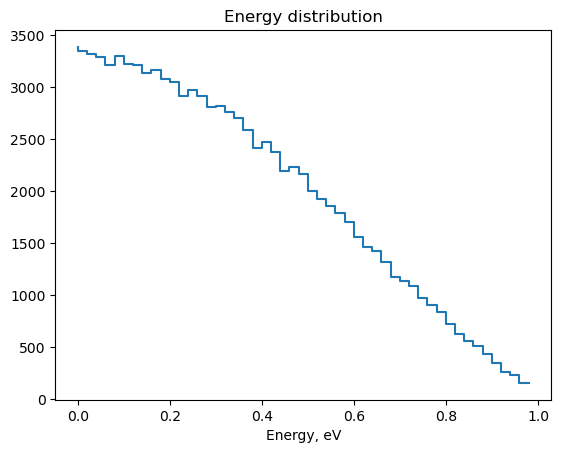

In [214]:
# dist = [rejection_sampler(f,(xgrid[0], xgrid[-1]),pmax1) for _ in range(10000)]
dist = [rejection_sampler(f,(xgrid[0], xgrid[-1]),pmax1) for _ in range(100000)]
gr, cnt = np.histogram(dist, 50)
# plt.semilogx()
plt.step(cnt[:-1], gr)
# plt.step(10**cnt[:-1]*1e9, gr)
plt.title("Energy distribution")
plt.xlabel("Energy, eV")

In [157]:
mceq_run.pman["mu+"]


        mu+:
        is_hadron     : False
        is_lepton     : True
        is_nucleus    : False
        is_stable     : False
        is_mixed      : False
        is_resonance  : False
        is_tracking   : False
        is_projectile : False
        mceqidx       : 5
        E_mix         : 0.0e+00 GeV

0.9931736212002785


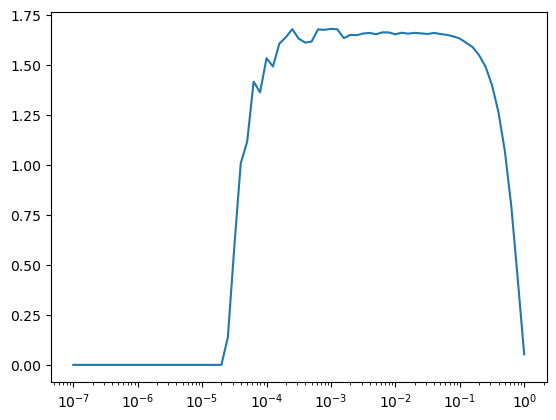

In [162]:

mceq_run._decays
mceq_run.pman[13]

pp = particlemanager.MCEqParticle(13, 0, e_grid)
pp.set_decay_channels(mceq_run._decays, mceq_run.pman)

#pp.decay_dists[11]

# pp.dNdec_dxlab(1e4, mceq_run.pman[14])

# plt.loglog(*pp.dNdec_dxlab(1e4, mceq_run.pman[-12]))
# plt.loglog(*pp.dNdec_dxlab(1e4, mceq_run.pman[11]))
# plt.loglog(*pp.dNdec_dxlab(1e4, mceq_run.pman[14]))
# pp.dNdec_dxlab(1e1, mceq_run.pman[11])[0]
from scipy.interpolate import interp1d
f = interp1d(*pp.dNdec_dxlab(1e6, mceq_run.pman[11]))
xgrid = pp.dNdec_dxlab(1e6, mceq_run.pman[11])[0]
xlin = np.linspace(0, 1, 100)

f(xgrid)
x0 = xgrid[0]
# plt.plot(xlin, f(x0*(1/x0)**xlin)*x0*(1/x0)**xlin*np.log(1/x0))
plt.semilogx(xgrid, f(xgrid))

from scipy import integrate
I1 = integrate.simpson(f(xgrid), xgrid)
print(I1)